In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import glob
import anacal
import xlens
import fitsio
import lsst.afw.image as afwImage
import astropy.table as astTable
from astropy.visualization import ZScaleInterval

In [2]:
def get_corr(noise_array):
    window_array = np.ones(noise_array.shape)
    pad_width = ((10, 10), (10, 10))
    window_array = np.pad(
        window_array,
        pad_width=pad_width,
        mode="constant",
        constant_values=0.0,
    )
    noise_array = np.pad(
        noise_array,
        pad_width=pad_width,
        mode="constant",
        constant_values=0.0,
    )
    ny, nx = window_array.shape

    npixl = int(48 // 2)
    npixr = int(48 // 2 + 1)
    noise_array = np.fft.fftshift(
        np.fft.ifft2(np.abs(np.fft.fft2(noise_array)) ** 2.0)
    ).real[
        ny // 2 - npixl : ny // 2 + npixr, nx // 2 - npixl : nx // 2 + npixr
    ]
    window_corr = np.fft.fftshift(
        np.fft.ifft2(np.abs(np.fft.fft2(window_array)) ** 2.0)
    ).real[
        ny // 2 - npixl : ny // 2 + npixr, nx // 2 - npixl : nx // 2 + npixr
    ]
    noise_array = noise_array / window_corr
    return noise_array

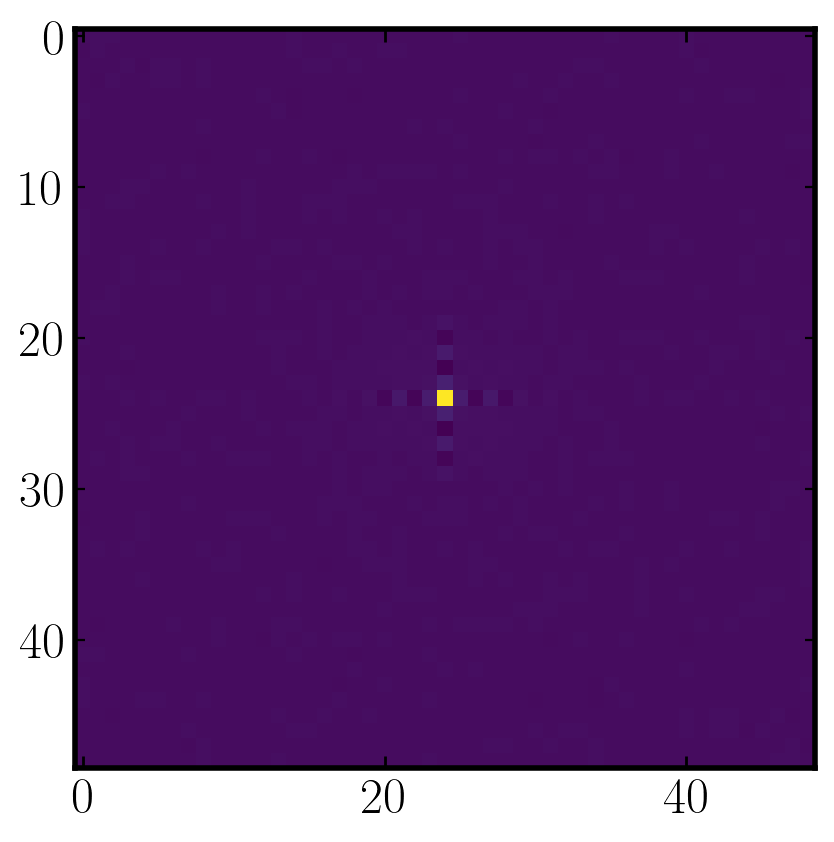

In [3]:
fname = "/work/xiangchong.li/work/hsc_s23b_sim2/systematics/20250301T190954Z/deepCoadd_systematics_noisecorr/10041/2/i/deepCoadd_systematics_noisecorr_10041_2_i_hsc_systematics_20250301T190954Z.fits"
noise_corr = fitsio.read(fname)

variance = np.amax(noise_corr)
noise_corr = noise_corr / variance
plt.imshow(noise_corr)

In [4]:
noise1 = anacal.noise.simulate_noise(
    seed=0,
    correlation=noise_corr,
    nx=1000,
    ny=1000,
    scale=0.168,
) * np.sqrt(variance)
cor1 = get_corr(noise1)

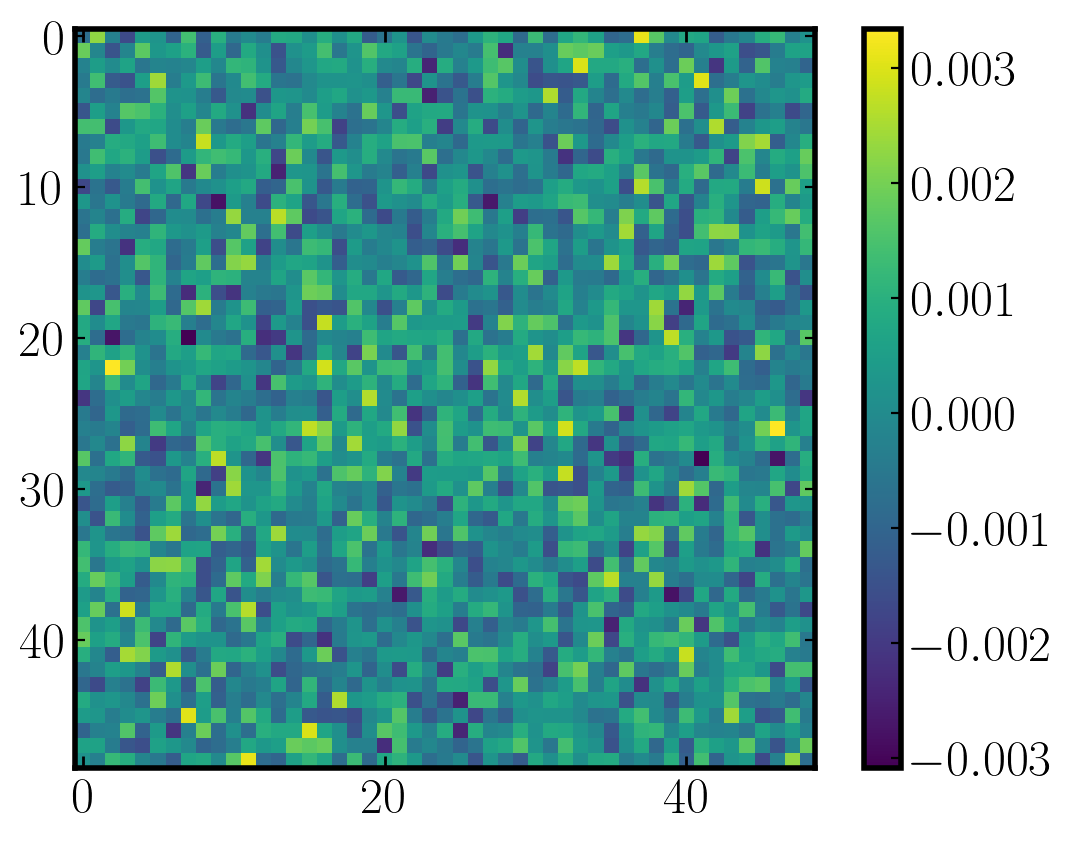

In [5]:
plt.imshow(cor1 / variance - noise_corr)
plt.colorbar()

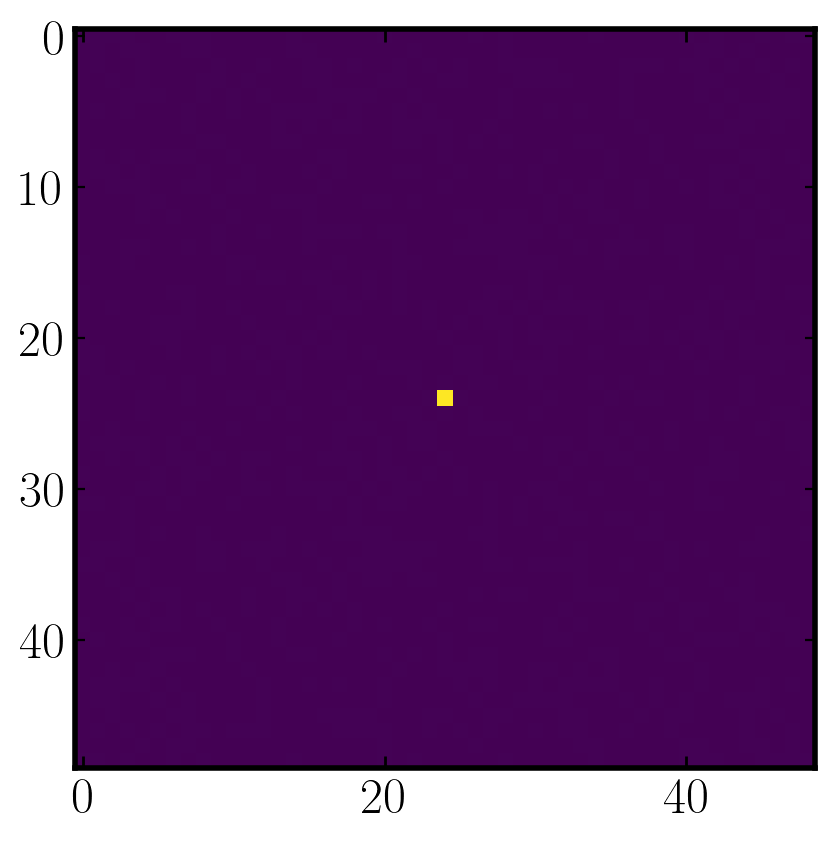

In [6]:
noise2 = (
    np.random.RandomState(0)
    .normal(
        scale=np.sqrt(variance),
        size=(1000, 1000),
    )
    .astype(np.float64)
)
cor2 = get_corr(noise2)
plt.imshow(cor2)

In [40]:
noise_corr[24, 27]

0.03419487

In [41]:
noise_corr[27, 24]

0.04338086

8.322539245816425e-05


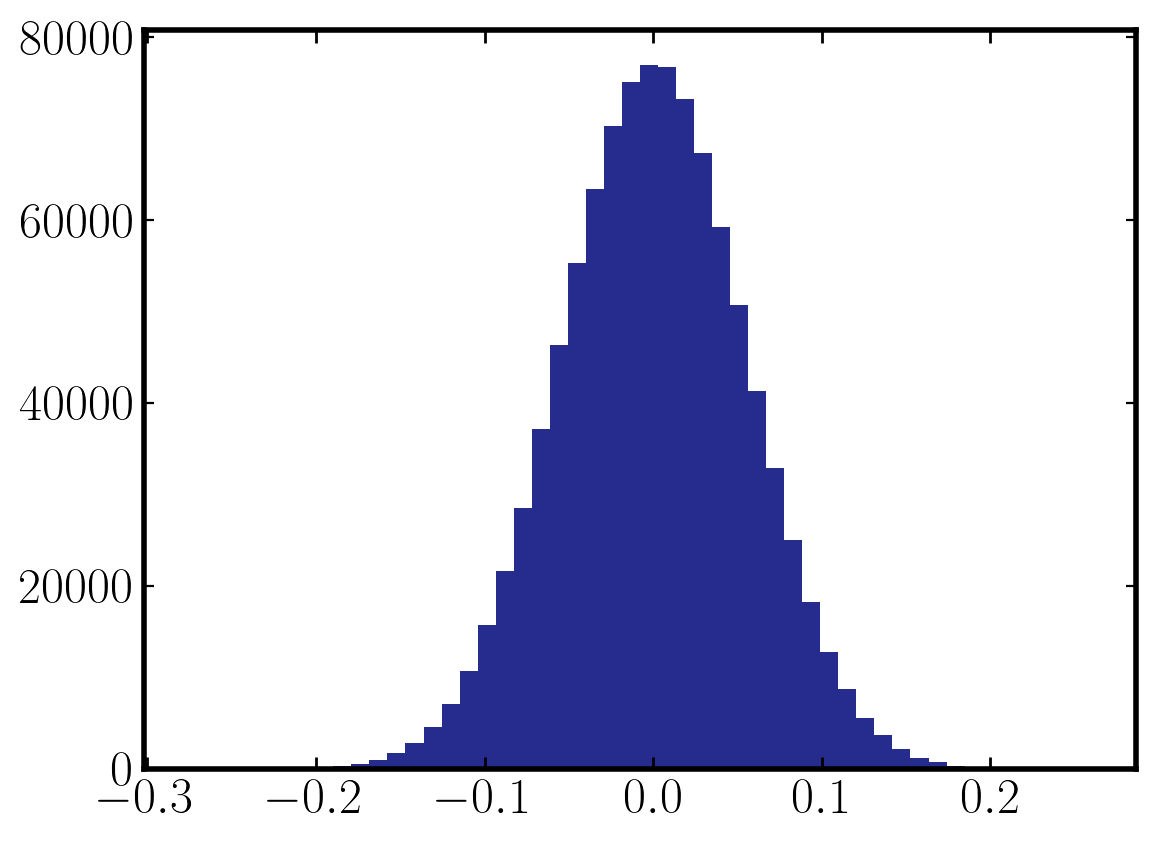

In [7]:
plt.hist(np.ravel(noise2), bins=50)
print(np.mean(noise2))

In [8]:
np.mean(anacal.noise.simulate_noise(
    seed=0,
    correlation=noise_corr,
    nx=6000,
    ny=6000,
    scale=0.168,
))

0.0005590182648959856

In [10]:
if False:
    fnames = glob.glob("/work/xiangchong.li/work/hsc_s23b_sim2/systematics/20250301T190954Z/deepCoadd_systematics_noisecorr/*/*/i/*")
    dd = np.zeros((49, 49))
    for fn in fnames:
        dd = dd + fitsio.read(fname)
    dd = dd / len(fnames)
    fitsio.write("/work/xiangchong.li/superonionGW/code/image/AnaCal/python/anacal/data/noise_correlation.fits", dd)

In [67]:
fnames = glob.glob("/work/xiangchong.li/work/hsc_s23b_sim/version1/fpfs_catalog/20250620T202325Z/sim_0_rot0_Coadd_fpfs_force/*/*/*.parq")
tplist = []
for ff in fnames:
    tract = int(ff.split("/")[-3])
    patch = int(ff.split("/")[-2])
    tplist.append((tract, patch))

In [110]:
irot = 0
imode = 0
for tp in tplist[2481: 2482]:
    tt = tp[0]
    pp = tp[1]
    dt = "20250620T090833Z"
    dt2 = "20250620T202325Z"
    basedir = "/work/xiangchong.li/work/hsc_s23b_sim/version1/"
    fname1 = os.path.join(
        basedir,
        f"anacal_catalog/{dt}/sim_{imode}_rot{irot}_Coadd_anacal_joint/{tt}/{pp}/sim_{imode}_rot{irot}_Coadd_anacal_joint_{tt}_{pp}_hsc_version1_anacal_catalog_{dt}.parq"
    )
    d1 = astTable.Table.read(fname1)
    
    fname2 = os.path.join(
        basedir,
        f"fpfs_catalog/{dt2}/sim_{imode}_rot{irot}_Coadd_fpfs_force/{tt}/{pp}/sim_{imode}_rot{irot}_Coadd_fpfs_force_{tt}_{pp}_hsc_version1_fpfs_catalog_{dt2}.parq"
    )
    d2 = astTable.Table.read(fname2)
    print(np.sum(d1["fpfs_e1"]) - np.sum(d2["i_fpfs1_e1"]))
    print(np.sum(d1["fpfs_de1_dg1"]) - np.sum(d2["i_fpfs1_de1_dg1"]))
    print(np.sum(np.abs(d1["flux"] - d2["flux"])))
    print(np.sum(np.abs(d1["dflux_dg1"] - d2["dflux_dg1"])))
    print(np.sum(np.abs(d1["wsel"] - d2["wsel"])))
    print(np.sum(np.abs(d1["dwsel_dg1"] - d2["dwsel_dg1"])))

-21598.804579932395
-514657054.4172331
0.0
0.0
0.0
0.0


In [78]:
upA = []
downA = []
upB = []
downB = []
for tp in tplist:
    tt = tp[0]
    pp = tp[1]
    dt = "20250620T090833Z"
    dt2 = "20250620T202325Z"
    basedir = "/work/xiangchong.li/work/hsc_s23b_sim/version1/"
    fname1 = os.path.join(
        basedir,
        f"anacal_catalog/{dt}/simCoadd_anacal_selbias_flux_anacal_jointfpfs/{tt}/{pp}/simCoadd_anacal_selbias_flux_anacal_jointfpfs_{tt}_{pp}_hsc_version1_anacal_catalog_{dt}.parq"
    )
    d1 = astTable.Table.read(fname1)
    upA.append(d1[0]["up1"])
    downA.append(d1[0]["down"])
    
    fname2 = os.path.join(
        basedir,
        f"fpfs_catalog/{dt2}/simCoadd_anacal_selbias_flux_fpfs_forcefpfs1/{tt}/{pp}/simCoadd_anacal_selbias_flux_fpfs_forcefpfs1_{tt}_{pp}_hsc_version1_fpfs_catalog_{dt2}.parq"
    )
    d2 = astTable.Table.read(fname2)
    upB.append(d2[0]["up1"])
    downB.append(d2[0]["down"])

In [81]:
upA = np.array(upA)
downA = np.array(downA)
upB = np.array(upB)
downB = np.array(downB)

In [97]:
msk = (np.abs(upA - upB) < 10)

In [98]:
np.sum(upB[msk]) / np.sum(downB[msk])

0.020016168762180566

In [94]:
tplist[ind]

(9337, 35)

In [99]:
ind

2481

In [96]:
upB[ind]

3682.5411361043716

In [95]:
upA[ind]

60.77065259210427

In [93]:
ind = np.where(np.abs(upA - upB) > 10)[0][0]

In [91]:
ind

array([2481])

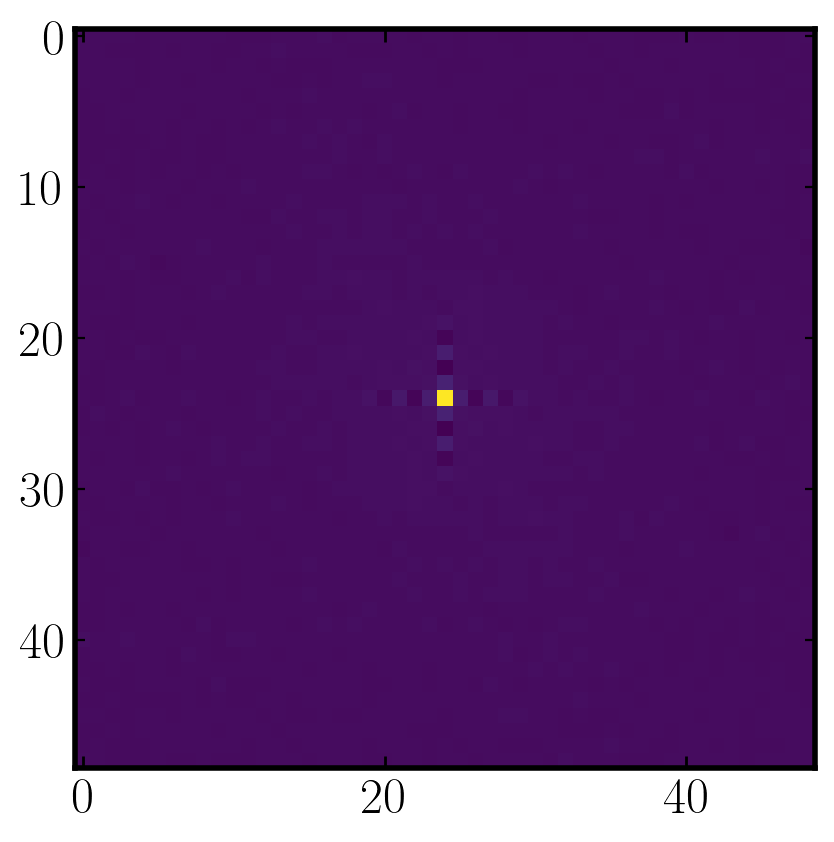

In [147]:
a=fitsio.read(
    "/work/xiangchong.li/work/hsc_s23b_sim2/systematics/20250301T190954Z/deepCoadd_systematics_noisecorr/9337/35/i/deepCoadd_systematics_noisecorr_9337_35_i_hsc_systematics_20250301T190954Z.fits"
)
plt.imshow(a)

(array([1.0000000e+00, 1.0000000e+00, 4.0000000e+00, 2.0000000e+00,
        5.0000000e+00, 4.0000000e+00, 1.5000000e+01, 8.3000000e+01,
        2.3496000e+05, 1.6786625e+07, 1.3567600e+05, 3.1505000e+04,
        1.5030000e+04, 5.6950000e+03, 2.8130000e+03, 1.9770000e+03,
        1.4890000e+03, 1.0920000e+03, 7.3400000e+02, 3.4800000e+02,
        2.4400000e+02, 1.9500000e+02, 1.3000000e+02, 7.3000000e+01,
        7.3000000e+01, 6.5000000e+01, 8.0000000e+01, 6.9000000e+01,
        7.1000000e+01, 9.1000000e+01, 1.0400000e+02, 7.4000000e+01,
        8.7000000e+01, 9.5000000e+01, 4.3000000e+01, 4.6000000e+01,
        4.2000000e+01, 3.9000000e+01, 5.9000000e+01, 4.2000000e+01,
        3.7000000e+01, 5.1000000e+01, 4.1000000e+01, 3.2000000e+01,
        2.9000000e+01, 1.3000000e+01, 1.0000000e+01, 3.0000000e+00,
        0.0000000e+00, 3.0000000e+00]),
 array([-3.26905966, -2.91698384, -2.56490779, -2.21283197, -1.86075604,
        -1.50868022, -1.15660429, -0.80452842, -0.45245254, -0.10037664

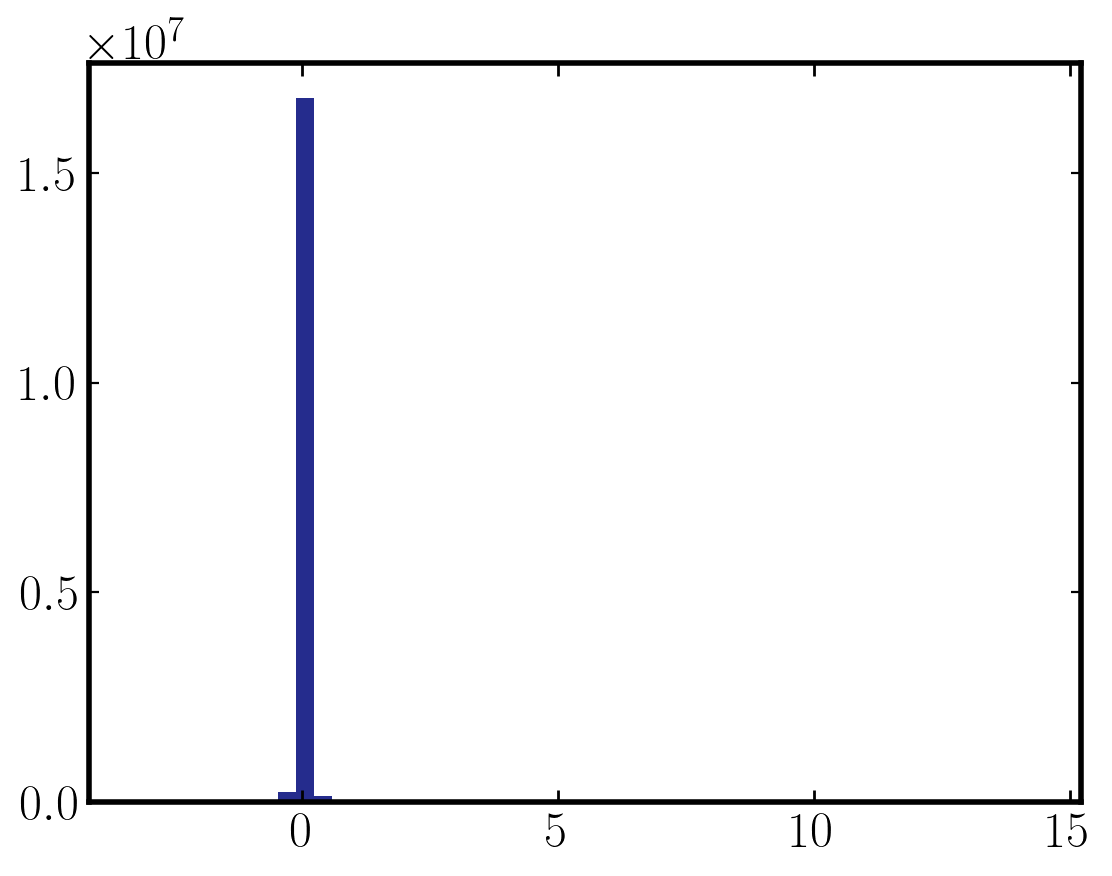

In [151]:
plt.hist(np.ravel(exp.image.array), bins=50)

In [113]:
exp = afwImage.ExposureF.readFits("/work/xiangchong.li/work/hsc_s23b_sim/version1/image/20250327T185256Z/sim_0_rot0_Coadd_calexp/9337/35/i/sim_0_rot0_Coadd_calexp_9337_35_i_hsc_version1_image_20250327T185256Z.fits")

In [123]:
np.min(d1["x1"]  / 0.168 - exp.getX0())

40.000002707027306

In [124]:
np.max(d1["x1"]  / 0.168 - exp.getX0())

4059.0000030476513

In [126]:
np.min(d1["x2"] / 0.168 - exp.getY0())

40.000001011956556

In [125]:
np.max(d1["x2"] / 0.168 - exp.getY0())

4158.0000013609715

In [127]:
exp.variance.array

array([[0.00232562, 0.00232562, 0.00232562, ..., 0.00232562, 0.00232562,
        0.00232562],
       [0.00232562, 0.00232562, 0.00232562, ..., 0.00232562, 0.00232562,
        0.00232562],
       [0.00232562, 0.00232562, 0.00232562, ..., 0.00232562, 0.00232562,
        0.00232562],
       ...,
       [0.00232562, 0.00232562, 0.00232562, ..., 0.00232562, 0.00232562,
        0.00232562],
       [0.00232562, 0.00232562, 0.00232562, ..., 0.00232562, 0.00232562,
        0.00232562],
       [0.00232562, 0.00232562, 0.00232562, ..., 0.00232562, 0.00232562,
        0.00232562]], dtype=float32)

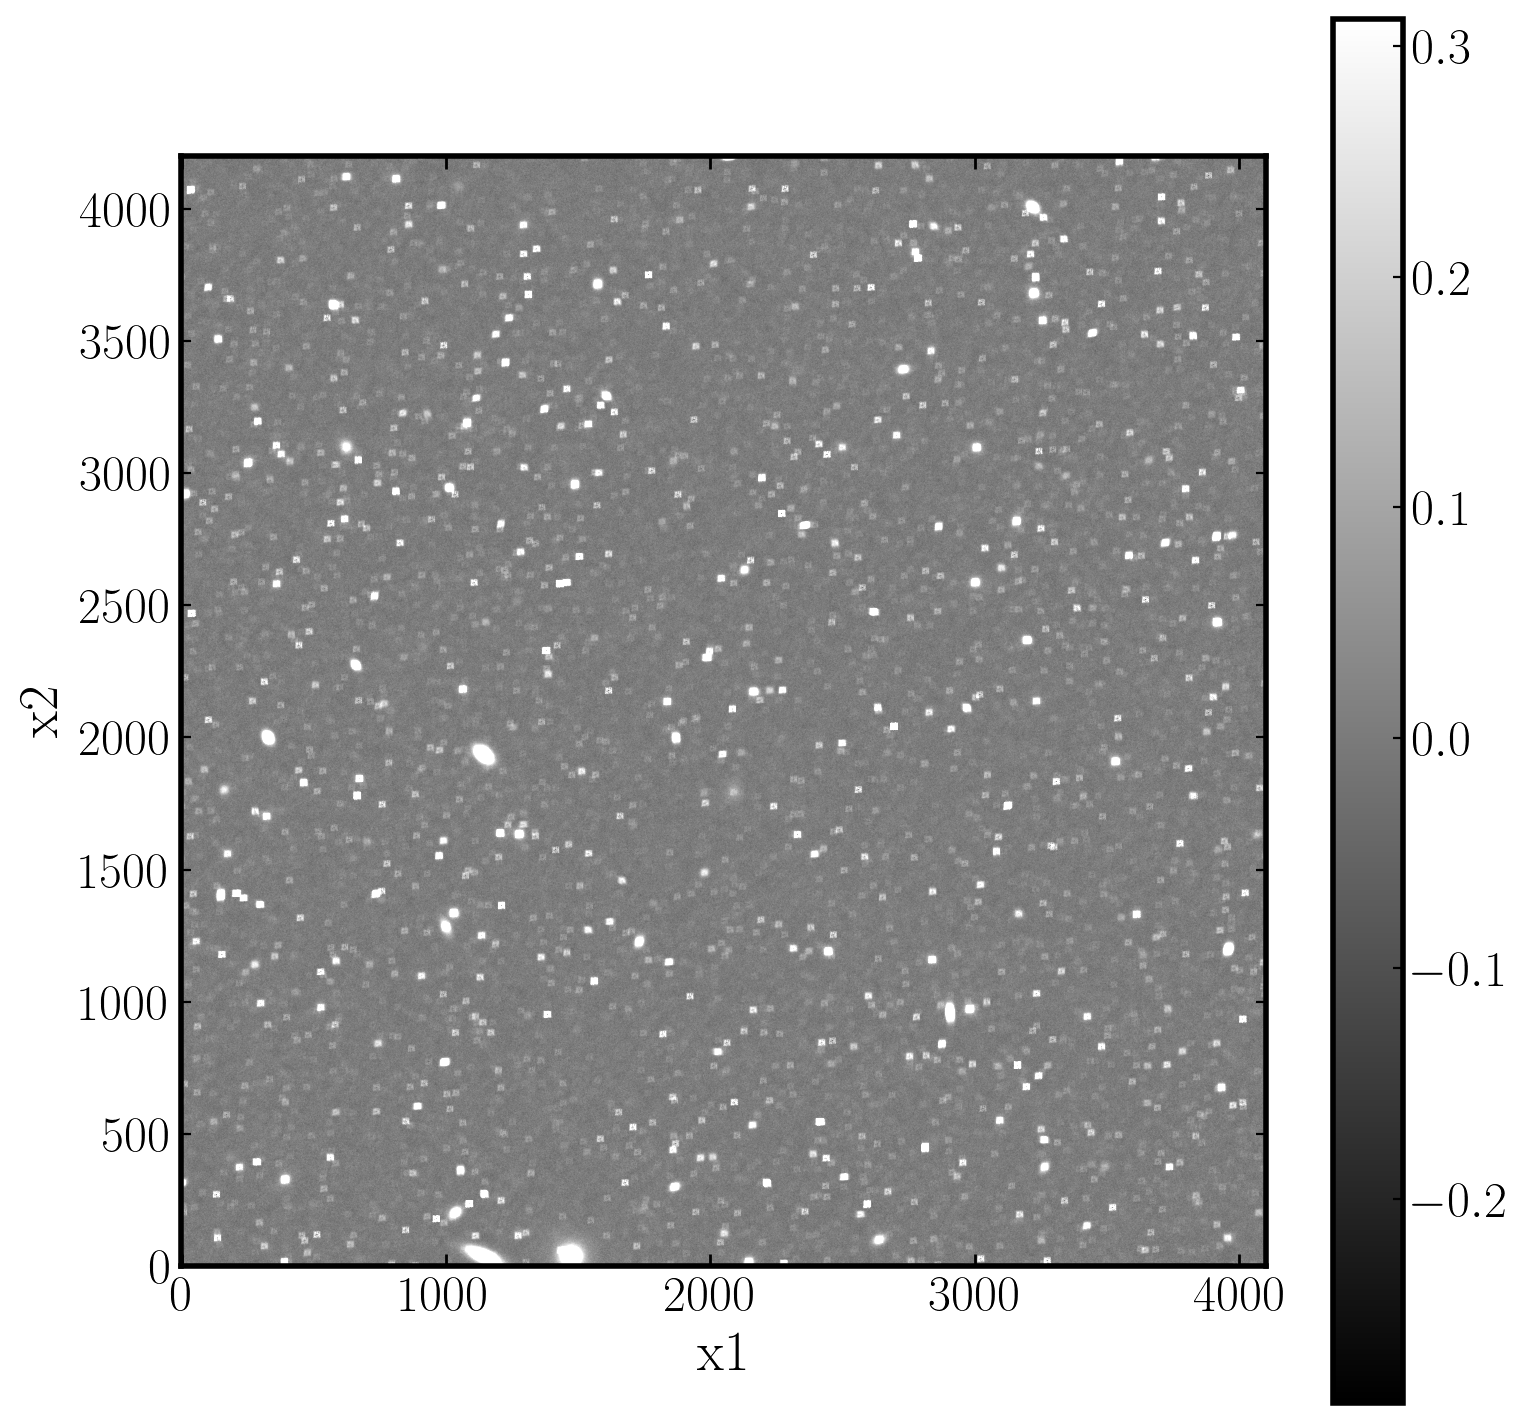

In [145]:
image = exp.image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.colorbar(im)
plt.show()

282


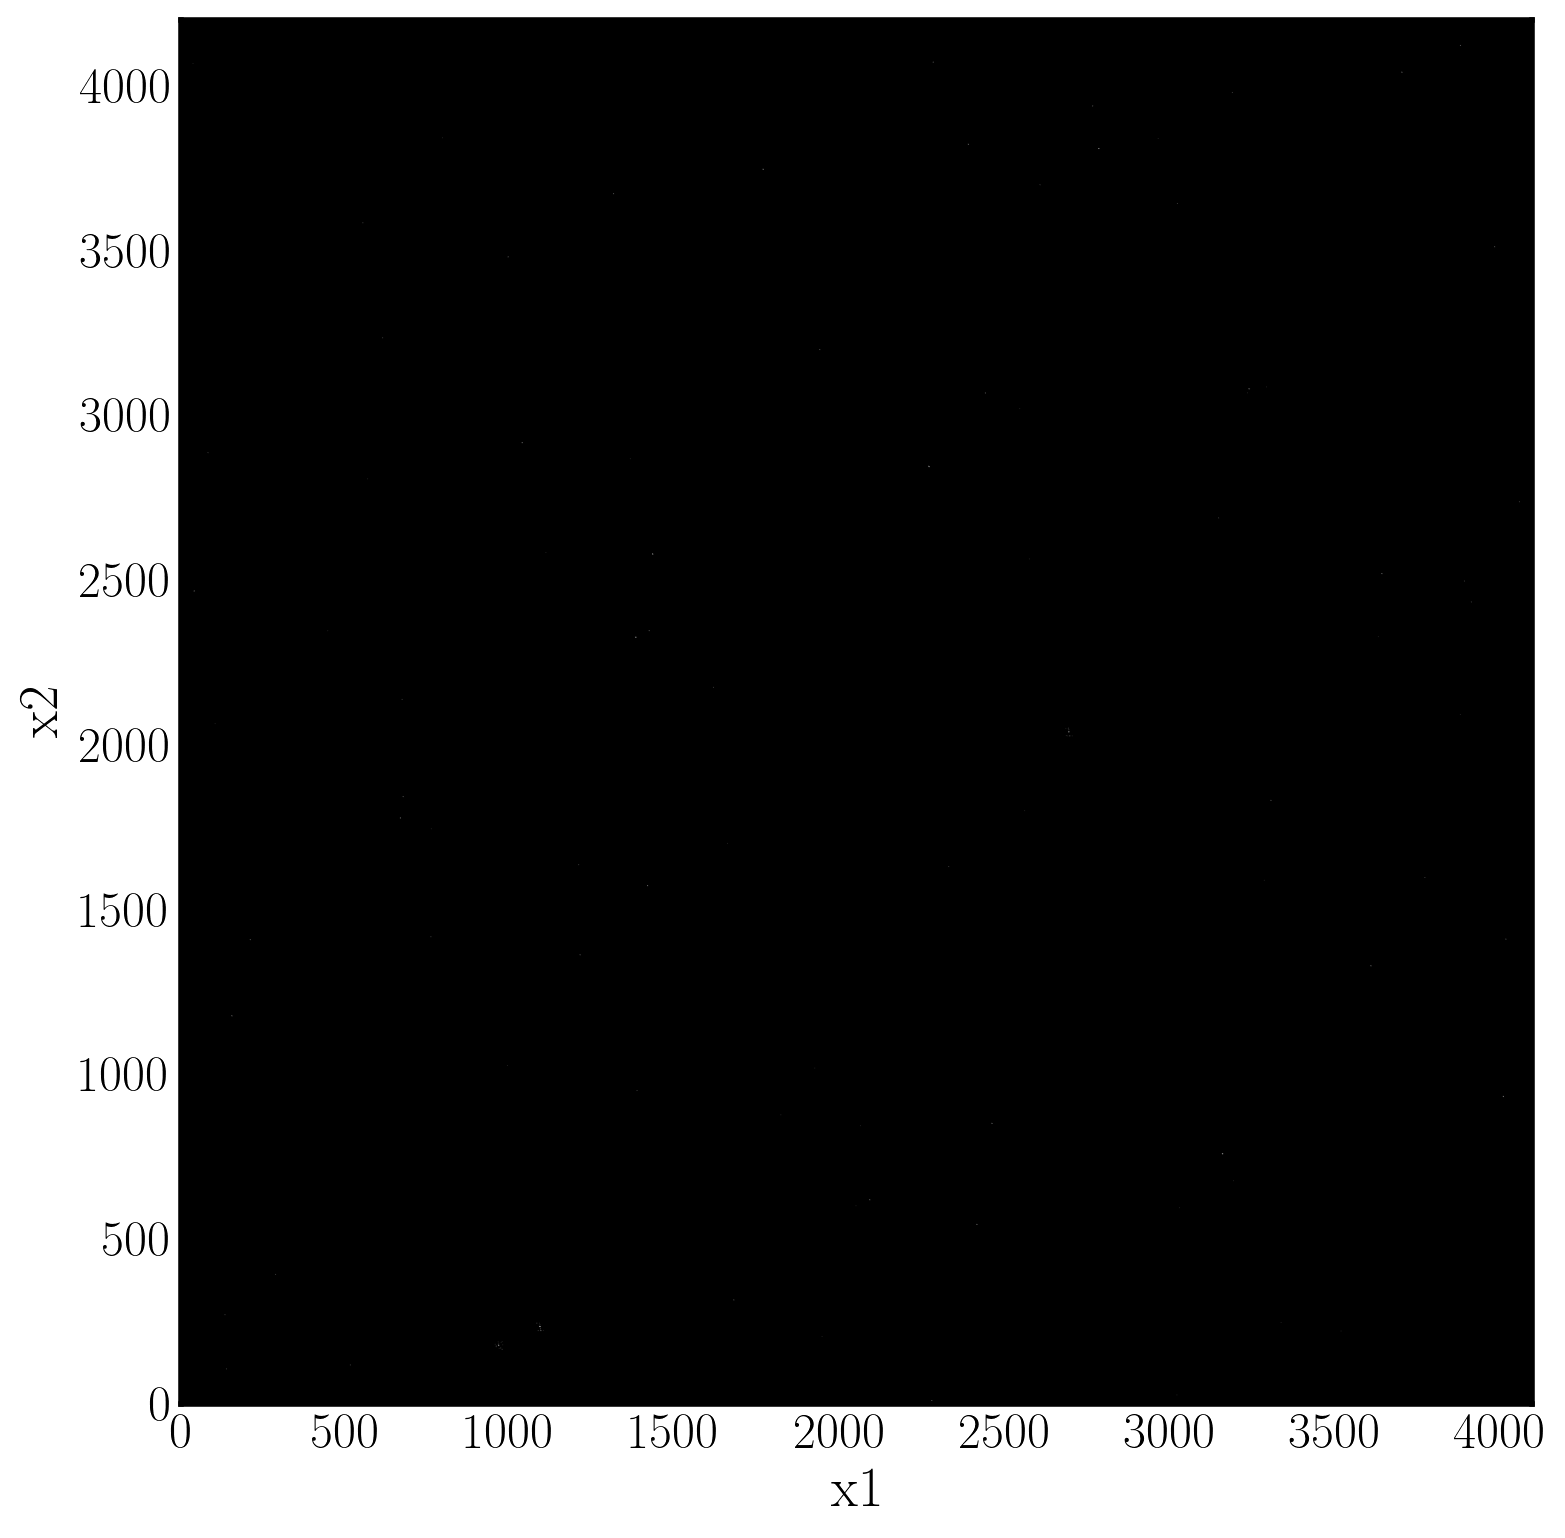

In [142]:
bitv = exp.mask.getPlaneBitMask([])
mask_array = (
    ((exp.mask.array & bitv) != 0)
    | (
        exp.image.array
        < (
            -6.0
            * np.sqrt(
                np.where(
                    exp.variance.array < 0,
                    0, exp.variance.array,
                )
            )
        )
    )
).astype(np.int16)

print(np.sum(mask_array))

image = mask_array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray')

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [135]:
d2["i_fpfs1_de1_dg1"]

973.6096410343229
219.63825762093853
0.3329172792374051
0.5378264235179566
0.9428446747297348
-3.69652329830327
-0.6701778811138235
-1.4360904443107918
0.21325491478834596
5.346671365796854
-1.1565422116667348


In [136]:
d1["fpfs_de1_dg1"]

1.162599617264683
-0.25737553826998294
0.437394621672512
0.3978199734717711
0.9397497736679679
0.726893394726366
0.03149399786597462
-0.9488065398768843
0.30007121550408966
0.3544193278912723
-0.2104617158512816


In [14]:
psf = fitsio.read("/work/xiangchong.li/work/hsc_s23b_sim2/systematics/20250301T190954Z/deepCoadd_systematics_psfcentered/9337/35/i/deepCoadd_systematics_psfcentered_9337_35_i_hsc_systematics_20250301T190954Z.fits")

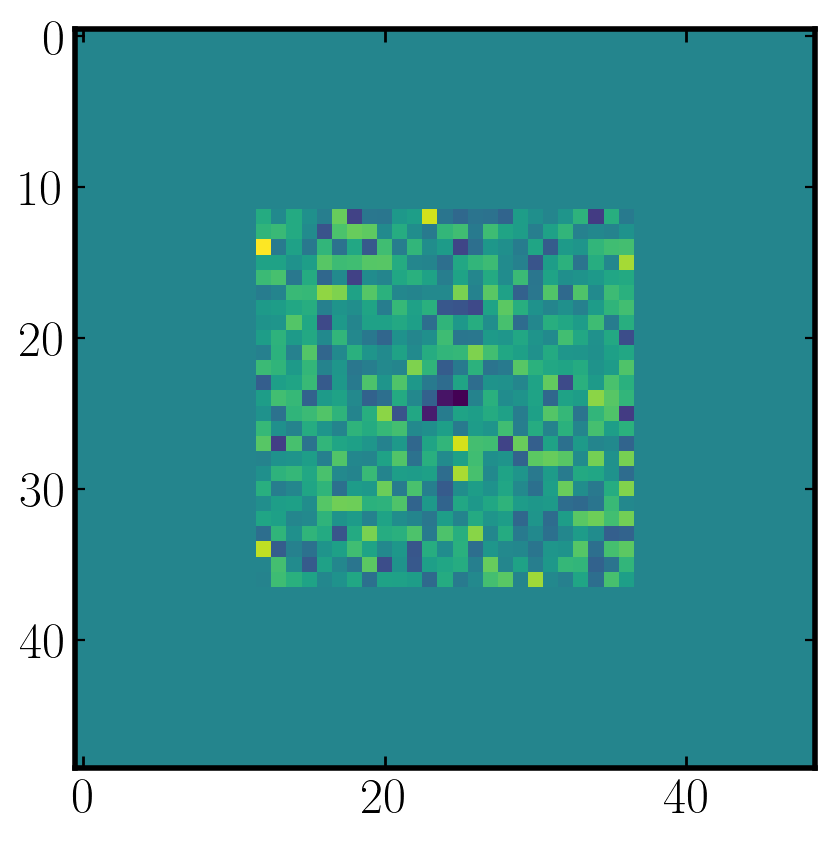

In [15]:
plt.imshow(psf)

In [19]:
from lsst.daf.butler import Butler

obs_repo = '/work/xiangchong.li/work/hsc_s23b_sim2'
obs_collection = 'version1/image'
butler = Butler(obs_repo, collections=obs_collection)
registry = obs_butler.registry
skymap = butler.get('skyMap', skymap="hsc")
dataId = {"skymap": "hsc", "tract": 9337, "patch": 35}
butler.pruneDatasets(["sim_0_rot0_Coadd_calexp"], dataIds=[dataId], unstore=True, unrecord=True)

TypeError: DirectButler.pruneDatasets() got an unexpected keyword argument 'dataIds'

In [21]:
butler.registry.removeDataset("sim_0_rot0_Coadd_calexp", dataId)

AttributeError: 'RegistryShim' object has no attribute 'removeDataset'

In [25]:
refs = list(butler.registry.queryDatasets("sim_0_rot0_Coadd_calexp", dataId=dataId))
butler.pruneDatasets(refs, disassociate=True, unstore=True)

TypeError: Butler is read-only.